In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle

from scripts.smdp_agent import SMDPQLearningAgent
from scripts.intraoption_agent import IntraOptionQLearningAgent
from scripts.taxi_utils import TaxiUtils as tu
from scripts.taxi_visualizer import TaxiVisualizer as tv
from scripts.taxi_visualizer import vis
from scripts.options import Option
from scripts.policies import MoveTaxiPolicy, EpsilonGreedyPolicy, OptimalPolicy, PickUpPassenger, DropOffPassenger, get_initiation_move_taxi, get_termination_move_taxi, get_termination_pick_passenger, get_termination_drop_passenger
from scripts.training import Trainer, trainingInspector, test_agent, plot_test_results, compute_decay

In [2]:
def vis_actions(actions, title):
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(title)
    tv.visualize_adjacency()
    tv.visualize_locations()
    tv.visualize_actions(actions)


    fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=10)

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.gca().invert_yaxis()

    plt.tight_layout()

In [3]:
color_map = {tu.RED:"Red", tu.GREEN:"Green", tu.YELLOW:"Yellow", tu.BLUE:"Blue"}
options = [
    Option(index = i, 
           initiation_set = get_initiation_move_taxi(tu.COLOR_TO_LOC[color]), 
           policy = MoveTaxiPolicy(tu.COLOR_TO_LOC[color]), 
           termination = get_termination_move_taxi(tu.COLOR_TO_LOC[color]), 
           seed=0,
           label = f"Go To {color_map[color]}"
    )
    for i, color in enumerate([tu.BLUE, tu.YELLOW, tu.GREEN, tu.RED])
]

/tmp/ipykernel_26476/4291134353.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=10)


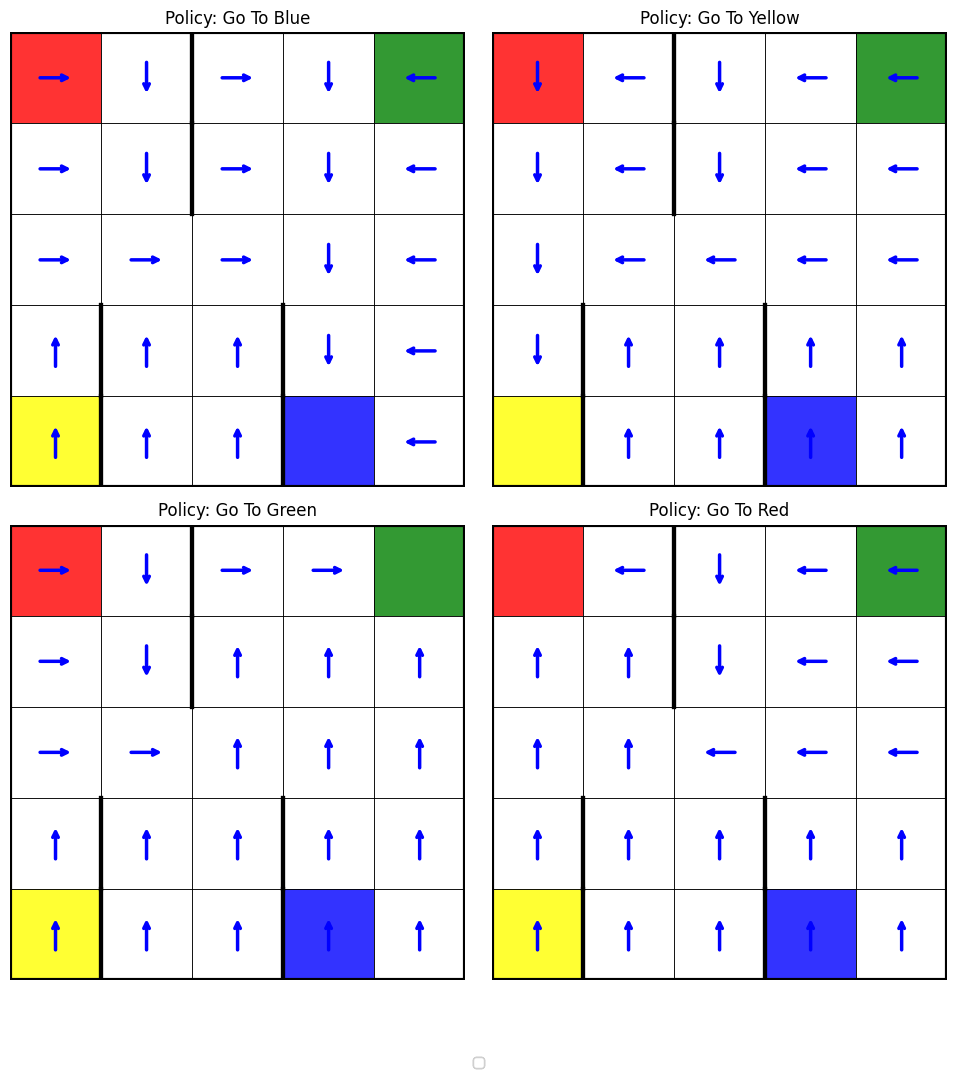

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, color in enumerate([tu.BLUE, tu.YELLOW, tu.GREEN, tu.RED]):
    actions = np.zeros((5, 5), dtype=np.int32)
    for taxi_row in range(5):
        for taxi_col in range(5):
            actions[taxi_row][taxi_col] = options[i].policy.act(
                tu.encode_env_state(taxi_row, taxi_col, tu.GREEN, tu.RED)
            )

    ax = axes[i // 2, i % 2]
    plt.sca(ax)
    vis_actions(actions, f"Policy: Go To {color_map[color]}")

plt.tight_layout()
plt.show()

In [5]:
initiation_set = [True for i in range(500)]

options = [
    Option(0, initiation_set, PickUpPassenger(), get_termination_pick_passenger(), seed=0, label="Pick up Passenger"),
    Option(1, initiation_set, DropOffPassenger(), get_termination_drop_passenger(), seed=0, label="Drop off Passenger")
]

/tmp/ipykernel_26476/4291134353.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=4, fontsize=10)


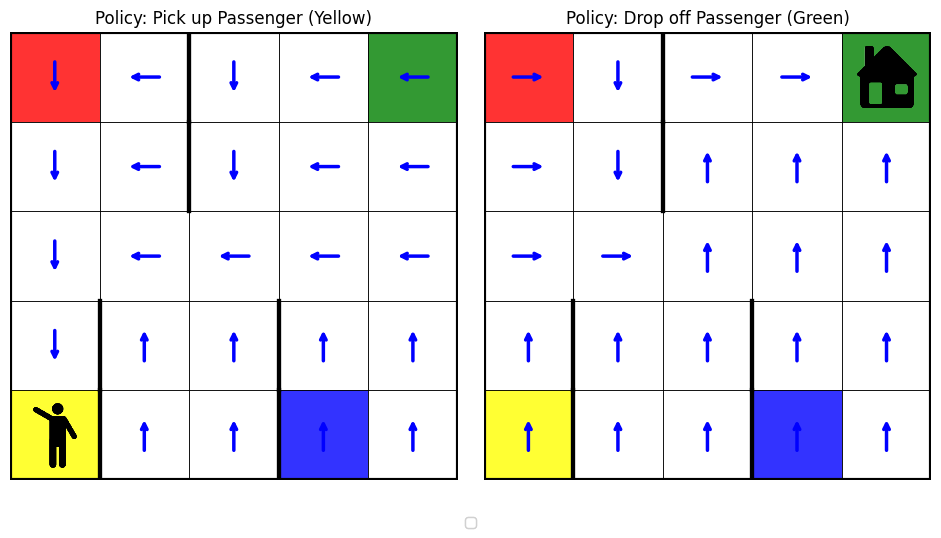

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
passenger_location = tu.YELLOW
destination = tu.GREEN

for i in range(2):
    actions = np.zeros((5, 5), dtype=np.int32)
    for taxi_row in range(5):
        for taxi_col in range(5):
            actions[taxi_row][taxi_col] = options[i].policy.act(
                tu.encode_env_state(taxi_row, taxi_col, passenger_location, destination)
            )

    ax = axes[i]
    plt.sca(ax)
    
    if i==0:
        vis_actions(actions, "Policy: " + options[i].label + f" ({color_map[passenger_location]})") 
        tv.visualize_passenger(tu.encode_env_state(3, 3, passenger_location, destination))
    else:
        vis_actions(actions, "Policy: " + options[i].label + f" ({color_map[destination]})") 
        tv.visualize_destination(tu.encode_env_state(3, 3, passenger_location, destination))

plt.tight_layout()
plt.show()